# Assignments by Felix Vernieuwe

---
---

## Assignment 3: Research Question 1
#### **QUESTION:** *Quantify the importance of global, contextual and personalised candidates in evaluation and output score*

---
---

**Pratical note:** this notebook reworks the Radek LGBM baseline to better compartmentalize candidate and feature generation, building upon the work of 02 - FE, and further inspired by Noah's template 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from lightgbm.sklearn import LGBMRanker
import os
import pathlib

from FelixVernieuwe.util import *
from scorers import mean_average_precision

%load_ext autoreload
%autoreload 2

setup_seaborn()

In [2]:
# Environment variables
DATA_PATH = "../../data/"
OUTPUT_PATH = "../../data/submissions/"

# Get OS profile root to get path to /.kaggle/kaggle.json
PROFILE_ROOT = os.environ.get("HOME", os.environ.get("USERPROFILE", ""))
KAGGLE_PATH = pathlib.Path(PROFILE_ROOT, ".kaggle/kaggle.json").as_posix()
print(initialise_kaggle(KAGGLE_PATH))

In [3]:
# Output description
SUBMISSION_NAME = "engineered_7_submission"
DESCRIPTION = "Retesting baseline with rewrite"
UPLOAD_TO_KAGGLE = True
INCLUDE_MISSING_CUSTOMERS = False

In [4]:
# Load in the datasets
articles = pd.read_parquet(DATA_PATH + "articles.parquet")
all_transactions = pd.read_parquet(DATA_PATH + "transactions_train.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")

In [5]:
# Features to train on
base_features = [
    'article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
    'perceived_colour_master_id', 'department_no', 'index_code',
    'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
    'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 
    
]

added_features = [
    'has_promotion', 'bestseller_rank', 'all_time_rank', 'price_sensitivity'
]

all_features = base_features + added_features

def join_all_features(transactions, articles, customers):
    # Join all features together
    transactions = transactions.merge(articles, on="article_id", how="left")
    transactions = transactions.merge(customers, on="customer_id", how="left")
    
    return transactions


def filter_feature_data(data):
    # Train only on available features in the data, and specified features above 
    available_features = [feature for feature in all_features if feature in data.columns]
    
    return data[available_features], available_features


def clean_up_transaction_data(data):
    # Clean up incoming data
    data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)
    data.sort_values(['week', 'customer_id'], inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    if "bought" not in data:
        data["bought"] = 1
        
    return data

In [6]:
# Reference week (i.e. the last week of our training data, any week after this can be considered part of the test set)
# In the current training set, the last week is 104, if we take this as reference, we will try to make predictions for week 105

REFERENCE_WEEK = all_transactions["week"].max()
# REFERENCE_WEEK = all_transactions["week"].max() - 1

# How many weeks to train on
TRAINING_INTERVAL = 10

#Output additional graphs and information
VERBOSE = False

---
## Feature Engineering
---

In [7]:
from features import *
from candidates import *
from data import *

In [8]:
# Filter out all transactions that are outside of the training interval
transactions = all_transactions[all_transactions["week"] >= REFERENCE_WEEK - TRAINING_INTERVAL]

In [9]:
# Split into train and test set
# DISCLAIMER: this concept was copied from Noah's ExperimentTemplate notebook (test_data is used for offline evaluation)
train_data, test_data = split_dataframe(transactions, transactions["week"] <= REFERENCE_WEEK)

#### General feature data
(does not get added to the training data, but is used to generate candidates)

In [10]:
bestsellers_per_week = most_sold_per_week(train_data, REFERENCE_WEEK)

#### General customer candidate data
(determines which customers are applicable for candidate generation)

In [11]:
candidate_customers, ref_week_candidate_customers = get_buying_customers_candidates(train_data, REFERENCE_WEEK)
candidates = []

#### Global Candidates (apply to every person)

In [12]:
# Add weekly bestsellers to each candidate customer as transaction candidates
bestseller_candidates = candidate_bestsellers_weekly(candidate_customers, ref_week_candidate_customers, bestsellers_per_week)
candidates.append(bestseller_candidates)

In [13]:
# Add new arrivals to each candidate customer as transaction candidates
new_arrival_candidates = candidate_new_arrivals(candidate_customers, ref_week_candidate_customers, all_transactions, REFERENCE_WEEK)
candidates.append(new_arrival_candidates)

#### Contextual Candidates (apply to groups of people)

In [14]:
# 

#### Personalised Candidates (apply to individuals)

In [15]:
# Recall previous purchases of customers (i.e. repeat article in the next week)
previous_purchase_candidates = candidate_previous_purchases(train_data, REFERENCE_WEEK)
candidates.append(previous_purchase_candidates)

### Combine Candidates

In [16]:
train_data["bought"] = 1

# Add all candidates together with the training data
train_data = pd.concat([train_data] + candidates, ignore_index=True)
train_data.fillna(0, inplace=True)

# Drop duplicate candidates and transactions
train_data.drop_duplicates(["customer_id", "article_id", "week"], inplace=True)

#### Features

In [17]:
# Weekly Bestseller feature
train_data = weekly_bestseller_feature(train_data, bestsellers_per_week)

In [18]:
# All time Bestseller feature
train_data = overal_bestseller_feature(train_data)

In [19]:
# Price sensitivity feature
train_data = price_sensitivity_feature(train_data, customers)

In [20]:
# New arrivals feature
train_data = product_age_feature(all_transactions, train_data)

In [21]:
# Promotion feature
train_data = discount_feature(train_data)

#### Final clean-up

In [22]:
# Removes the first week of the training data (since it does not have any data it can base itself on for some features)
train_data = train_data[train_data['week'] != train_data['week'].min()]

---
## Model Training
---

In [23]:
# Data clean-up
train_data = clean_up_transaction_data(train_data)

# Split training data into two sets
train_data, test_candidates = split_dataframe(train_data, train_data["week"] < REFERENCE_WEEK)

In [24]:
# Join all features together
train_data = join_all_features(train_data, articles, customers)

# Gives amount of items purchased per customer per week (used for training the ranking)
train_bins = train_data.groupby(["week", "customer_id"])["article_id"].count().values

# Train only on specified features
train_X, available_features = filter_feature_data(train_data)
train_y = train_data["bought"]

In [25]:
ranker = LGBMRanker(
    force_row_wise=True,
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10 if VERBOSE else 0,
)

ranker = ranker.fit(train_X, train_y, group=train_bins)

# Get the relative importance of the feature according to the ranker
feature_importance = feature_importance_df(ranker, available_features)

A:\Programs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
A:\Programs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
A:\Programs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
A:\Python\ai-project-23-24\FelixVernieuwe\util.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_title("Feature Importance")


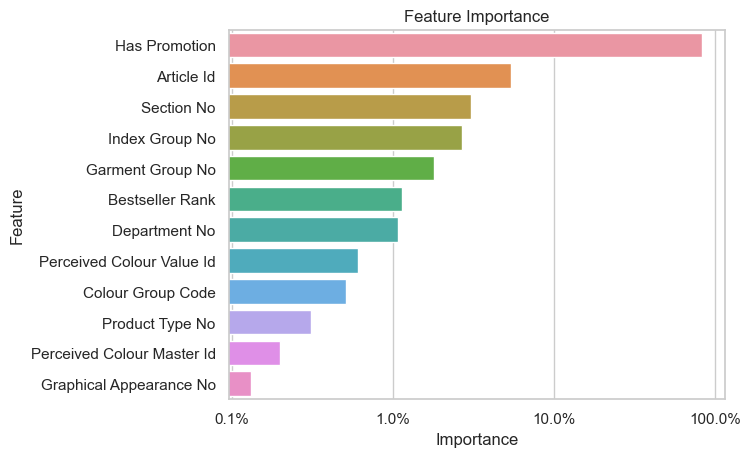

In [67]:
# Graph importances on bar chart
if VERBOSE:
    graph_feature_importance(feature_importance)

---
## Prediction generation
---

In [27]:
test_candidates = test_candidates.drop_duplicates(["customer_id", "article_id", "sales_channel_id"]).copy()
test_candidates = join_all_features(test_candidates, articles, customers)
test_X, available_features = filter_feature_data(test_candidates)

In [28]:
def calculate_predictions(candidates, features, ranker, k=12):
    """
    Retrieves dataframe for top 12 candidate articles per customer
    NOTE: Partially adapted from Noah's ExperimentTemplate notebook
    
    :param candidates: Filtered dataframe combining only selected features
    :param features: Filtered dataframe combining the features of transactions, articles and customers
    :param ranker: Trained ranker model
    :param k: Number of articles to predict per customer
    :return: Dataframe containing the top k articles per customer
    """

    # Predict on test set
    features = features.copy()
    features["score"] = ranker.predict(candidates)
    features.sort_values(["customer_id", "score"], ascending=False, inplace=True)
    features = features.groupby("customer_id").head(k).reset_index(drop=True)
    
    return features[["article_id", "customer_id", "score"]]

In [29]:
predicted_candidates = calculate_predictions(test_X, test_candidates, ranker)

---
## Model Evaluation / Submission
---

In [35]:
# Products that also may prove to be generally interesting (excluding bestsellers)
# interesting_products = []
# if promoted_articles is not None:
#     current_promos = promoted_articles[promoted_articles["week"] == REFERENCE_WEEK - 1]
#     bestsellers_df = pd.DataFrame({"article_id": bestsellers})
#     interesting_products = bestsellers_df.merge(current_promos, on="article_id", how="inner")
#     interesting_products = interesting_products[interesting_products["has_promotion"] == True]["article_id"].tolist()

# Bestselling products in the previous week
bestsellers = transactions[transactions["week"] == REFERENCE_WEEK - 1]["article_id"].value_counts().head(12).index.tolist()
# interesting_products = set(interesting_products)

In [36]:
predicted_candidates = predicted_candidates[["article_id", "customer_id"]]

In [68]:
# Add extra articles to customers that do not have any predictions
missing_customers = pd.DataFrame({"customer_id": customers["customer_id"].unique()})
missing_customers = missing_customers[~missing_customers["customer_id"].isin(test_candidates["customer_id"].unique())]
missing_customers = missing_customers.merge(pd.DataFrame({"article_id": bestsellers}), how="cross")

# Join the two dataframes together (predicted candidates and missing customers)
predicted_candidates = pd.concat([predicted_candidates, missing_customers], ignore_index=True)

In [38]:
# DISCLAIMER: Evaluate test set/leaderboard concept copied from Noah's ExperimentTemplate notebook

# Evaluate on the test set (known data)
if test_data.empty is False:
    # Filter test_data to only the reference week
    ground_truth_purchases = test_data[test_data["week"] == REFERENCE_WEEK]
    
    # Get dataframe of customers and their bought articles, grouped by customer and as set, for convenient comparison operations
    ground_truth_purchases = ground_truth_purchases.groupby("customer_id")["article_id"].apply(set).reset_index()
    predicted_purchases = predicted_candidates.groupby("customer_id")["article_id"].apply(list).reset_index()

    # Rename column to match the predicted candidates
    ground_truth_purchases.rename(columns={"article_id": "purchases"}, inplace=True)
    predicted_purchases.rename(columns={"article_id": "predictions"}, inplace=True)
    
    truth_prediction = mean_average_precision(predicted_purchases, ground_truth_purchases)
    truth_prediction

In [90]:
# Evaluate on leaderboard set (unknown data)
if test_data.empty is True:  
    # Read in sample submission (customer_id, prediction)
    submission = pd.read_csv(DATA_PATH + "sample_submission.csv")
    
    # Convert to a dictionary and replaces the sample submission predictions with our own
    predictions = generate_submission_df(submission, predicted_candidates)
       
    # Write submission to zipped csv
    predictions.to_csv(OUTPUT_PATH + f"{SUBMISSION_NAME}.csv.gz", index=False)
    
    # Upload to kaggle
    if UPLOAD_TO_KAGGLE:
        result = upload_to_kaggle(OUTPUT_PATH + f"{SUBMISSION_NAME}.csv.gz", DESCRIPTION)
        # Pretty print result
        print(json.dumps(result, indent=4))

{'code': 401, 'message': 'Unauthorized access'}


KeyError: 'createUrl'